# Final Project

Run on Google Cloud Platform, 4 CPUs, 1 GPU Nvidia Tesla K80

   The Galaxy Zoo is a project motivated to provide information about galaxy features to astronomers in order to more easily acquire data required for their research. Observers at home follow a series of questions about an image in order to identify various morphological features of galaxies. Galaxy morphology can tell us much more than just the shape of a certain galaxy. Spiral galaxies tell us that the galaxy is still young, and that its arms are active regions of star formation. Even more useful than the class of a galaxy are the specific features within it. If an astronomer wanted to study ongoing mergers within galaxies, then they could search Galaxy Zoo for images with multiple nuclei and strong tidal features. If one wanted to study or find new black holes, they could also search for nuclear bulges within the images. The same goes for bars and star birth. Labeling galaxy features creates a gateway to many more specific problems and studies. The problem with Galaxy Zoo is that it requires many man hours to get these results. Not only does each observer have to answer a series of questions for each image, but they need many observers to do a single image in order to get good probabilities. The hope for this project is to be accurately recreate the human probabilities given the images. This will prove that the model will be able to perform just as well as several humans on these images, thus decreasing the amount of man hours required to label these images and giving astronomers better turnaround time for acquiring data.<br> <br>
    The original goal of this project were to participate in this Kaggle competition https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/overview/the-galaxy-zoo-decision-tree. This would involve training on ~61,000 images and testing on ~80,000 images. I plan to use a CNN in order to accompish this. The model would take in an image of a galaxy, and train given the probabilities for each feature for that image. I would then test the output of the model to predict these probabilities given these images. The preprocessing of the data would include creating a data loader in order to train in batches, croping, resizing, random horizontal flips, and random rotations in order to make the model rotation invariant. <br> <br>
    The project will ultimately have to descope to training on less images, and using a validation loss rather than a Kaggle loss. The training and testing would take multiple days, even with a GPU. For sake of time and resources, I have decided to descope to training on 8000 images and validating on 2000 images.

In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import pandas as pd
from skimage import io, transform
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import mean_squared_error

import time
start = time.time()


In [108]:
# Create a pytorch dataset to allow for batch training
class GalaxyDataset(Dataset):

    def __init__(self, root_dir, file_list, label_path, transform=None):
        self.root_dir = root_dir
        self.file_list = file_list
        self.labels = pd.read_csv(label_path)
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.file_list[idx])
        image = Image.open(img_name)
        im_name = self.labels.iloc[idx][0]
        label = self.labels.iloc[idx][1:].values
#         print(type(im_name), type(label))
        if self.transform:
            image = self.transform(image)

        return image,label,im_name

In [234]:
#transform by cropping about the center, random rotation, random horizontal flip, random vertical flip, and resizing
transform1 = transforms.Compose([transforms.CenterCrop(244),
    transforms.RandomRotation((0,360)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize(127),
    transforms.ToTensor()
])
train = 'train1'
# test = '/Users/kevintang/Classes/astro128/course-materials/Labs/final_proj/data/images_test_rev1'
sol_path = 'training_subset_solutions.csv'
# label = pd.read_csv('data/training_subset_solutions.csv')
# print(os.listdir(train))
training = os.listdir(train)
np.random.shuffle(training)
trainlist = training[:8000]
vallist = training[8000:10000]
#create data sets and batch loaders
trainset = GalaxyDataset(root_dir=train, 
                         file_list = trainlist,
                         label_path = sol_path,
                        transform=transform1)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=32,
                                          shuffle=True)

valset = GalaxyDataset(root_dir=train, 
                        file_list = vallist,
                       label_path = sol_path,
                        transform=transform1)

valloader = torch.utils.data.DataLoader(valset, 
                                         batch_size=32,
                                         shuffle=True)
#37 feature probabilities
classes = ('Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1',
          'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 
           'Class7.2','Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 
           'Class8.7','Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2', 'Class10.3', 'Class11.1', 
           'Class11.2','Class11.3', 'Class11.4', 'Class11.5', 'Class11.6')

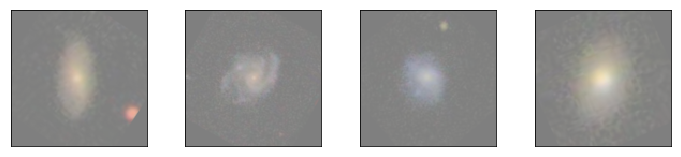

In [235]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, label,filename = dataiter.next()

fig, axes = plt.subplots(1, 4, figsize=(12,2.5))
for idx, image in enumerate(images[:4]):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])


In [236]:
class CNN(nn.Module):
    def __init__(self, num_classes=37):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 64, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(inplace=True)
# #             nn.MaxPool2d(kernel_size=3),
#             nn.Conv2d(512, 1024, kernel_size=3),
#             nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
        self.classifier = nn.Sequential(
            nn.Linear(4608, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [237]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
is_train = True
model = CNN().to(device)


In [247]:
#hyperparameters
import torch.optim as optim
num_epochs = 2
learning_rate = .0015
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
model_to_load = 'model.ckpt' # This is the model to load during testing, if you want to eval a previously-trained model.



In [248]:
#training the model
if not is_train:
    num_epochs = 0
    model.load_state_dict(torch.load('model.ckpt'))

print('Beginning training..')
total_step = len(trainloader)
loss_list=[]
image_names = []
for epoch in range(num_epochs):
    # Training
    print('epoch {}'.format(epoch))
    for i, (local_batch,local_labels,local_names) in enumerate(trainloader):
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)
        
        # Forward pass
        outputs = model.forward(local_ims)
        loss = criterion(outputs, local_labels.float())
        image_names.append(local_names)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            

end = time.time()
print('Time: {}'.format(end - start))



Beginning training..
epoch 0
Epoch [1/2], Step [4/250], Loss: 0.0294
Epoch [1/2], Step [8/250], Loss: 0.0268
Epoch [1/2], Step [12/250], Loss: 0.0256
Epoch [1/2], Step [16/250], Loss: 0.0259
Epoch [1/2], Step [20/250], Loss: 0.0278
Epoch [1/2], Step [24/250], Loss: 0.0295
Epoch [1/2], Step [28/250], Loss: 0.0263
Epoch [1/2], Step [32/250], Loss: 0.0292
Epoch [1/2], Step [36/250], Loss: 0.0317
Epoch [1/2], Step [40/250], Loss: 0.0203
Epoch [1/2], Step [44/250], Loss: 0.0218
Epoch [1/2], Step [48/250], Loss: 0.0227
Epoch [1/2], Step [52/250], Loss: 0.0305
Epoch [1/2], Step [56/250], Loss: 0.0290
Epoch [1/2], Step [60/250], Loss: 0.0248
Epoch [1/2], Step [64/250], Loss: 0.0223
Epoch [1/2], Step [68/250], Loss: 0.0288
Epoch [1/2], Step [72/250], Loss: 0.0272
Epoch [1/2], Step [76/250], Loss: 0.0265
Epoch [1/2], Step [80/250], Loss: 0.0217
Epoch [1/2], Step [84/250], Loss: 0.0292
Epoch [1/2], Step [88/250], Loss: 0.0270
Epoch [1/2], Step [92/250], Loss: 0.0204
Epoch [1/2], Step [96/250], Lo

In [249]:
# validation error
from sklearn.metrics import mean_absolute_error
print('Beginning Testing..')
with torch.no_grad():
    error = 0
    total = 0
    predicted_list = []
    groundtruth_list = []
    for (local_batch,local_labels,_) in valloader:
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = model.forward(local_ims).cpu().numpy()
#         _, predicted = torch.max(outputs.data, 1)
        error += local_labels.size(0)*mean_squared_error(local_labels.cpu().numpy(),outputs)
        total += local_labels.size(0)
        predicted_list.extend(outputs)
        groundtruth_list.extend(local_labels.cpu().numpy())
    print(error/total)

Beginning Testing..
0.02701457281102703


In [254]:
#training error
with torch.no_grad():
    error_t = 0
    total_t = 0
    predicted_list_t = []
    groundtruth_list_t = []
    for (local_batch,local_labels,_) in trainloader:
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = model.forward(local_ims).cpu().numpy()
#         _, predicted = torch.max(outputs.data, 1)
        error_t += local_labels.size(0)*mean_squared_error(local_labels.cpu().numpy(),outputs)
        total_t += local_labels.size(0)
        predicted_list_t.extend(outputs)
        groundtruth_list_t.extend(local_labels.cpu().numpy())
    print(error_t/total_t)

0.02664232114595262


In [246]:
print("RMSE validation:",np.sqrt(error/total))

RMSE validation: 0.16573670591287185


In [255]:
print("RMSE training", np.sqrt(error_t/total_t))

RMSE training 0.1632247565351305


In [256]:
print(predicted_list[0], predicted_list[90])

[0.38583606 0.49810687 0.0256448  0.10956604 0.39281175 0.08340533
 0.31199616 0.20541143 0.18773666 0.03326579 0.16283818 0.17241362
 0.02342007 0.21226601 0.698687   0.14468881 0.18835178 0.06612828
 0.02802321 0.0178363  0.03978029 0.03984289 0.05895457 0.03161917
 0.00593041 0.07728919 0.0137691  0.03328899 0.09348108 0.07100395
 0.04080772 0.01117738 0.08040499 0.02435421 0.01069413 0.00147303
 0.07728289] [ 4.30807352e-01  5.63836813e-01  3.12949345e-02  1.16817474e-01
  4.47249830e-01  9.49648842e-02  3.51525009e-01  2.22827569e-01
  2.19331458e-01  4.04394604e-02  1.88021153e-01  1.88069880e-01
  2.44737156e-02  2.25258946e-01  7.91970432e-01  1.57649755e-01
  2.08975166e-01  7.16015697e-02  2.33386233e-02  1.93517003e-02
  3.06838751e-02  4.14287150e-02  5.73665649e-02  3.00907791e-02
  3.32625350e-03  8.27407986e-02  1.72527414e-02  3.15563083e-02
  1.06260598e-01  7.63561726e-02  4.68947291e-02  1.30693298e-02
  9.04513896e-02  2.32018717e-02  7.13562127e-04 -2.96088075e-03


Note that for each entry, the values do not differ too much, very suspicious

In [275]:
#calculate the loss for each entry in training
losses_t = []
for i,lis in enumerate(predicted_list_t):
    loss = np.sqrt(mean_squared_error(groundtruth_list_t[i],lis))
    losses_t.append(loss)

In [288]:
#find good and bad examples and calculate validation losses
bad = []
good = []
losses = []
for i,lis in enumerate(predicted_list):
    loss = np.sqrt(mean_squared_error(groundtruth_list[i],lis))
    losses.append(loss)
    if loss > .3:
        bad.append(i)
    elif loss < .07:
        good.append(i)

In [263]:
#print index, class, loss, mean value of true probabilities
means = []
for i,classi in enumerate(classes):
    loss = np.sqrt(mean_squared_error(np.array(groundtruth_list)[:,i],np.array(predicted_list)[:,i]))
    mean = np.mean(np.array(groundtruth_list)[:,i])
    means.append(mean)
    print(i ,classi, loss, mean)

0 Class1.1 0.2836526336526752 0.427349697
1 Class1.2 0.29864012154152125 0.5479085104999999
2 Class1.3 0.03757538499203326 0.024741799000000002
3 Class2.1 0.21984714239616712 0.1106829473385
4 Class2.2 0.3034457642187998 0.437225563162
5 Class3.1 0.17385134766210886 0.101476448106
6 Class3.2 0.2461692349522943 0.3357491150565
7 Class4.1 0.29284923335671065 0.22649340614150001
8 Class4.2 0.1746459492443278 0.2107321570205
9 Class5.1 0.09290608466553892 0.0430672045265
10 Class5.2 0.19605657872876966 0.1800442029575
11 Class5.3 0.17968542884788052 0.179653475512
12 Class5.4 0.05850559496054295 0.034460681903500004
13 Class6.1 0.21707761862796335 0.2208549325
14 Class6.2 0.21967159327387836 0.7791450675
15 Class7.1 0.23592836722397922 0.1654881211905
16 Class7.2 0.21624013791727406 0.207363416014
17 Class7.3 0.10872904882222048 0.054498160627000004
18 Class8.1 0.09983829086412818 0.034652424132999994
19 Class8.2 0.02688425889357861 0.012867224647
20 Class8.3 0.056284442987010457 0.0331881

In [264]:
m = np.tile(means,(2000,1))
np.sqrt(mean_squared_error(m,predicted_list))


0.013974698843872832

The mean squared error between the mean of true probabilities and the predicte values is extremely low. 

In [265]:
b = np.where(np.array(groundtruth_list)[:,1] > .75, 1, 0)
print(np.sum(b)/len(b))

0.3265


Low proportion of high values compared to the mean, underfit to these points

RMSE: 0.3157866974580765
[0.00000000e+00 9.99491000e-01 5.09000000e-04 7.01462770e-02
 9.29344723e-01 7.03594808e-01 2.25749915e-01 9.29344723e-01
 0.00000000e+00 2.12699127e-01 4.67297760e-01 2.30332513e-01
 1.90153220e-02 6.48730000e-01 3.51270000e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.34935840e-01 5.13794160e-01
 0.00000000e+00 1.71576390e-02 0.00000000e+00 5.29886380e-02
 0.00000000e+00 7.14489520e-02 8.57895771e-01 0.00000000e+00
 9.29344723e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.39600253 0.5370271  0.02429254 0.10826403 0.43229872 0.10358639
 0.33293048 0.22389215 0.20851368 0.03872271 0.18274894 0.18808556
 0.02343317 0.21746676 0.74100184 0.14698023 0.18543199 0.06970551
 0.03391906 0.01920043 0.03856914 0.03726625 0.04449881 0.02661694
 0.00136968 0.07044479 0.01541529 0.02980643 0.1144902  0.07842305
 0.0411871  0.01421658 0.09048671 0.02533288 0.00843751 0.00493278
 0.0848

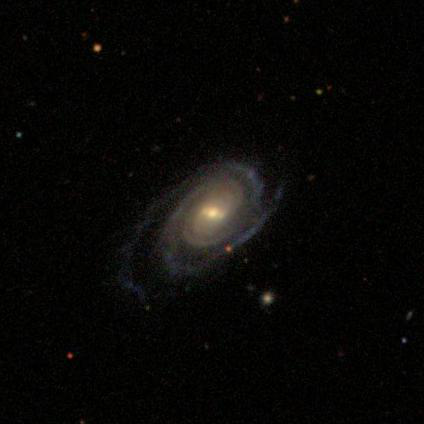

In [282]:
#Performs poorly
print("RMSE:", np.sqrt(mean_squared_error(groundtruth_list[bad[0]],predicted_list[bad[0]])))
print(groundtruth_list[bad[0]])
print(predicted_list[bad[0]])
Image.open('train1/'+vallist[bad[0]])

Text(0.5, 1.0, 'Predicted vs True Probability')

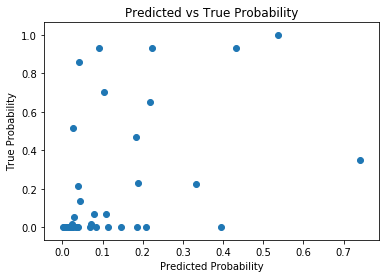

In [268]:
plt.scatter(predicted_list[bad[0]], groundtruth_list[bad[0]])
plt.ylabel('True Probability')
plt.xlabel('Predicted Probability')
plt.title('Predicted vs True Probability')

RMSE: 0.06004646919422685
[0.441172   0.552333   0.006496   0.08584912 0.46648388 0.0386188
 0.42786508 0.19295639 0.27352749 0.         0.18447432 0.25514289
 0.02686667 0.111976   0.888024   0.01728512 0.37508973 0.04879715
 0.07461342 0.01868129 0.         0.01868129 0.         0.
 0.         0.05726136 0.02858776 0.         0.13073683 0.06221956
 0.         0.0151438  0.01334197 0.         0.         0.
 0.16447063]
[4.17631328e-01 5.71116924e-01 2.27971524e-02 1.20186545e-01
 4.53655601e-01 1.04046829e-01 3.48308742e-01 2.39731863e-01
 2.08063424e-01 3.60867791e-02 2.00672448e-01 1.85671702e-01
 2.42170449e-02 2.26889148e-01 7.82569528e-01 1.62839353e-01
 1.89921305e-01 6.64872974e-02 3.22001502e-02 2.13266127e-02
 4.36472148e-02 4.69386801e-02 5.23177907e-02 2.29866449e-02
 8.38470925e-03 7.83887208e-02 1.51478238e-02 4.08647060e-02
 1.07748047e-01 8.56652334e-02 4.87559810e-02 1.16462577e-02
 1.00504406e-01 2.21001673e-02 4.64760233e-03 9.34891868e-05
 8.97742882e-02]


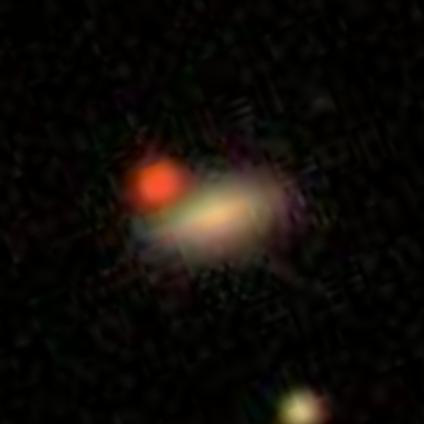

In [279]:
#Performs well
print("RMSE:", np.sqrt(mean_squared_error(groundtruth_list[good[0]],predicted_list[good[0]])))
print(groundtruth_list[good[0]])
print(predicted_list[good[0]])

Image.open('train1/'+vallist[good[1]])

Text(0.5, 1.0, 'Predicted vs True Probability')

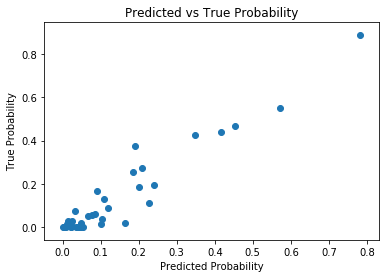

In [270]:
plt.scatter(predicted_list[good[0]], groundtruth_list[good[0]])
plt.ylabel('True Probability')
plt.xlabel('Predicted Probability')
plt.title('Predicted vs True Probability')


RMSE training: 0.1632247565351305


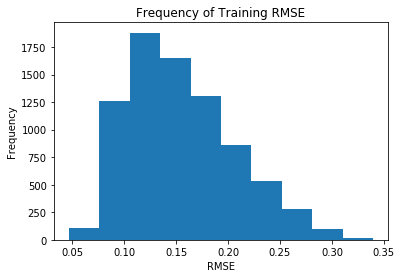

In [285]:
plt.hist(losses_t)
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Frequency of Training RMSE')
print("RMSE training:",np.sqrt(error_t/total_t))

RMSE validation: 0.16436110492153255


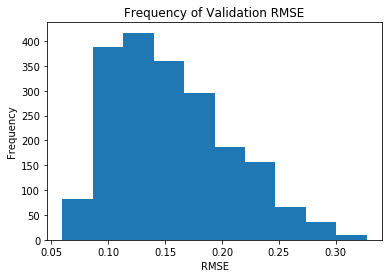

In [289]:
plt.hist(losses)
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Frequency of Validation RMSE')
print("RMSE validation:",np.sqrt(error/total))

Text(0.5, 1.0, 'Predicted vs True Probability for Class1.2')

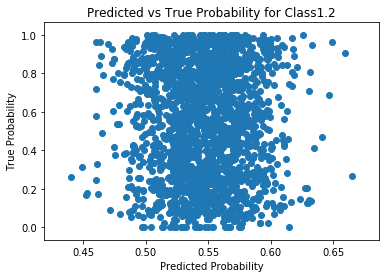

In [278]:
plt.scatter(np.array(predicted_list)[:,1],np.array(groundtruth_list)[:,1])
plt.ylabel('True Probability')
plt.xlabel('Predicted Probability')
plt.title('Predicted vs True Probability for Class1.2')

The residuals are very poor, but what is more interesting is the predicted probabilities only have a very small range. Not exactly sure how to adjust for this, perhaps some kind of normalization to MSE?

# Conclusion

Ultimately, the success of the model is limited by the amount of training data. I believe that my model suffers from underfitting as it seems to predict values close to the mean of each category, thus performing well on images whose labels have probabilities close to the mean. Additionally, the training accuracy is too similar to the validation accuracy, a major symptom of underfitting. It often happens that probabilities become close to 0 or 1, which is when the model performs very poor, still predicting values from the .3-.7 range. This is where the majority of the error occurs. However, given the amount of training data and resources I have, I am not too upset with my results. Making my results better would either require and ensemble of models or more training data, both of which require much more time and resources.

I have many more ideas for improvements. 
1. Experiment more with the data preprocessing: I have currently applied center crop, random rotation, random horizontal flip, random vertical flip. I would like to see what combinations would yield the best results. 
2. See if I can change my model enough to fit to just a subset of probabilities more accurately, then build on that.
3. Train different nets on different parts of the image, will probably yield more robust and consistent results. Use bagging or boosting methods.
4. Train different nets outputing a set of probabilities that are normalized to 1. For example, one net gets class 1.1, 1.2 and 1.3, and another net gets different. Then recombine the results. 
5. General things like playing around with architecture and hyperparameter tuning.

Overall, there is a lot of improvement to be made, but the model is still able to reproduce some of the human probabilities fairly well. Another question is whether the human probabilities are even trustworthy in the first place, perhaps the models probabilities are more trustworthy? Regardless, that is not the point of the project. The model performs the best on picture where humans are not sure, which is a little weird, but can still be helpful. If humans are better at detecting images which are clear and easy to distinguish features, the model can take care of difficult to see pictures that humans may be unsure or take too long on, as it will likely choose probabilities close to humans in a fraction of the time. This maybe useful in preprocessing data for Galaxy Zoo, getting rid of images that make humans unsure, and thus are unfit for data analysis by real astronomers.

I learned a lot during this project especially how to build a machine learning notebook like this from the ground up. Creating the dataloader, model, training, and validation created a way for me to do this in the future. Even if the results may not be as favorable, working with image data and training a neural network on it is something I have always wanted to do. 